In [25]:
import numpy as np
import seaborn as sn
import tensorflow as tf
import pandas as pd
import scipy.io as spio
from pathlib import Path
from math import floor, ceil
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import backend as K
from sklearn.metrics import classification_report, confusion_matrix
import plotly
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
CONTROL_DICT = {
    "EPOCHS": 50,
    "cross_validation_size": 0.7,
    "model_parameters": {
        "optimizer": "adam",
        "loss_function": "mse",
        "first_layer": {
            "neurons": 50,
            "activation_function": "tanh"
        },
        "second_layer": {
            "neurons": 50,
            "activation_function": "tanh"
        }
    }
}

In [26]:
def get_heatmap_confusion_matrix(df: pd.DataFrame):
    plt.figure(figsize = (15,10))
    df_cm = pd.DataFrame(confusion_matrix(df.real, df.predicted, normalize="true"), range(1,4,1), range(1,4,1))
    sn.heatmap(df_cm, annot=True)


def get_model(model_selector: str, train_x: dict) -> Sequential:
    model = Sequential()
    if model_selector == "VLSTM": #Vanilla LSTM        
        model.add(
            LSTM(units=CONTROL_DICT["model_parameters"]["first_layer"]["neurons"], 
                activation=CONTROL_DICT["model_parameters"]["first_layer"]["activation_function"],
                input_shape=train_x[0].shape))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        
    elif model_selector == "SLSTM": #Stacked LSTM
        model.add(LSTM(units=CONTROL_DICT["model_parameters"]["first_layer"]["neurons"], 
                     activation=CONTROL_DICT["model_parameters"]["first_layer"]["activation_function"], 
                     return_sequences=True, 
                     input_shape=train_x[0].shape))
        model.add(LSTM(units=CONTROL_DICT["model_parameters"]["second_layer"]["neurons"], 
                       activation=CONTROL_DICT["model_parameters"]["second_layer"]["activation_function"]))
        model.add(Dense(1))
        model.compile(optimizer=CONTROL_DICT["model_parameters"]["optimizer"], 
                      loss=CONTROL_DICT["model_parameters"]["loss_function"])
        
    return model

def plot_groups(df: pd.DataFrame):    
    real_groups = df.groupby("real")
    t1 = real_groups.get_group(1).groupby("predicted").count()
    t2 = real_groups.get_group(2).groupby("predicted").count()
    t3 = real_groups.get_group(3).groupby("predicted").count()
    plt.rcParams['figure.figsize'] = [15, 10]
    labels = t1.index
    x = np.arange(len(labels))
    width = 0.25
    fig, ax = plt.subplots()
    first_data_bar = [t1.real.loc[1], t2.real.loc[1], t3.real.loc[1]]
    second_data_bar = [t1.real.loc[2], t2.real.loc[2], t3.real.loc[2]]
    third_data_bar = [t1.real.loc[3], t2.real.loc[3], t3.real.loc[3]]


    rects1 = ax.bar(x - width, first_data_bar, width, label='Predicted as 1')
    rects2 = ax.bar(x, second_data_bar, width, label='Predicted as 2')
    rects3 = ax.bar(x + width, third_data_bar, width, label='Predicted as 3')
    ax.set_xlabel('Correct class')
    ax.set_ylabel('Occurences')
    ax.set_title('classified as in correct bin')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)
    ax.bar_label(rects3, padding=3)

    #fig.tight_layout()

    plt.show()

Import of data 

In [4]:
train_set = spio.loadmat("../deepFold_train", squeeze_me=True)
test_set = spio.loadmat("../deepFold_test", squeeze_me=True)

In [5]:
X_train = train_set["x_train"][:ceil(CONTROL_DICT["cross_validation_size"]*len(train_set["x_train"]))]
y_train = pd.DataFrame(train_set["y_train"])[[0]].iloc[:ceil(CONTROL_DICT["cross_validation_size"]*len(train_set["y_train"]))]

X_cv = train_set["x_train"][ceil(CONTROL_DICT["cross_validation_size"]*len(train_set["x_train"])):]
y_cv = pd.DataFrame(train_set["y_train"])[[0]].iloc[ceil(CONTROL_DICT["cross_validation_size"]*len(train_set["y_train"])): ]

X_test = test_set["x_test"]
y_test = pd.DataFrame(test_set["y_test"])[[0]]


Construction of model



In [ ]:
model = get_model(model_selector="SLSTM", 
                  train_x=X_train)

In [24]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=CONTROL_DICT["EPOCHS"], 
          verbose=1, 
          shuffle=False)

Epoch 1/20
5571/5571 [==============================] - 212s 37ms/step - loss: 0.2189
Epoch 2/20
5571/5571 [==============================] - 206s 37ms/step - loss: 0.2176
Epoch 3/20
5571/5571 [==============================] - 223s 40ms/step - loss: 0.2167
Epoch 4/20
5571/5571 [==============================] - 206s 37ms/step - loss: 0.2164
Epoch 5/20
5571/5571 [==============================] - 235s 42ms/step - loss: 0.2145
Epoch 6/20
5571/5571 [==============================] - 293s 53ms/step - loss: 0.2142
Epoch 7/20
5571/5571 [==============================] - 225s 40ms/step - loss: 0.2133
Epoch 8/20
5571/5571 [==============================] - 219s 39ms/step - loss: 0.2129
Epoch 9/20
5571/5571 [==============================] - 211s 38ms/step - loss: 0.2115
Epoch 10/20
5571/5571 [==============================] - 209s 38ms/step - loss: 0.2106
Epoch 11/20
5571/5571 [==============================] - 210s 38ms/step - loss: 0.2100
Epoch 12/20
5571/5571 [=============================

In [31]:
#Predict testset.
y_pred = model.predict(X_test, verbose=0)
df = pd.DataFrame(columns=["predicted", "real"])
df["predicted"] = pd.Series(y_pred.mean(axis=1).round()).astype(int)
df["real"] = y_test[0]

In [1]:
print(classification_report(y_true=y_test, y_pred=pd.Series(y_pred.mean(axis=1).round()).astype(int), labels=[1, 2, 3]))
print("Correct classified percentage of class 1 is: {}%".format(round(((t1.real.loc[1]*100)/t1.real.sum()),3)))
print("Correct classified percentage of class 2 is: {}%".format(round(((t2.real.loc[2]*100)/t2.real.sum()),3)))
print("Correct classified percentage of class 3 is: {}%".format(round(((t3.real.loc[3]*100)/t3.real.sum()),3)))
print("Correct percentage of testset 1 realtion between (predicted_1/(predicted_1 + predicted_3)) is: {}%".format(round(((t1.real.loc[1]*100)/(t1.real.loc[1]+ t1.real.loc[3])),3)))
print("Correct percentage of testset 3 realtion between (predicted_3/(predicted_1 + predicted_3)) is: {}%".format(round(((t3.real.loc[3]*100)/(t3.real.loc[1]+ t3.real.loc[3])),3)))

NameError: name 'classification_report' is not defined

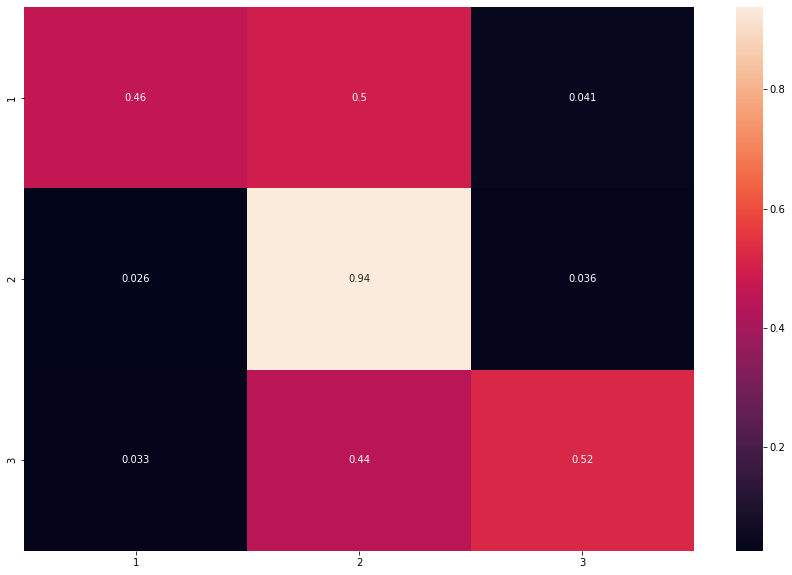

In [33]:
get_heatmap_confusion_matrix(df)

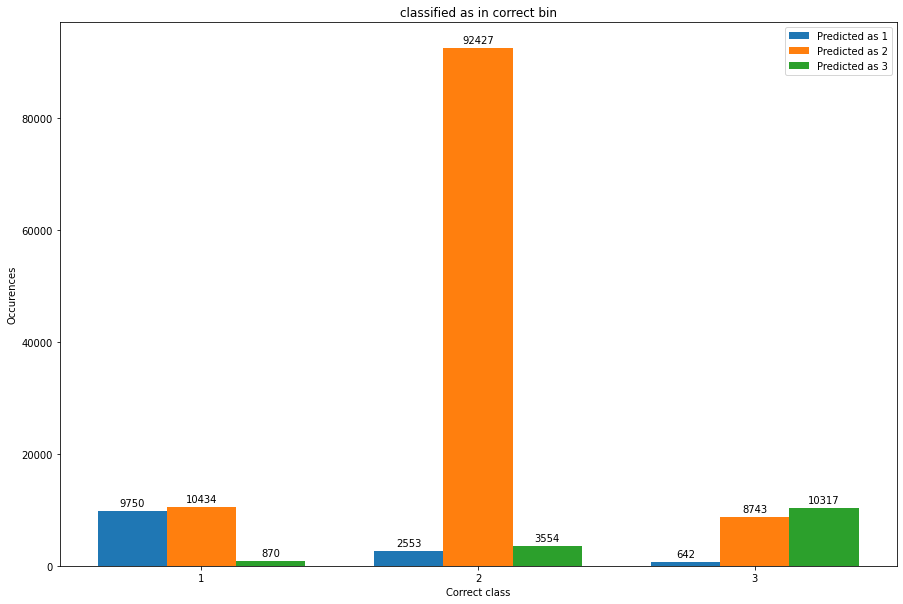

In [34]:
plot_groups(df)